In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.stats as sts

## MFA

In [ ]:
class MajoritySimulator:

    def __init__(self, size=100, initial_density=0.1, radius=1):
        '''
        Initialize new MajoritySimulator object with default parameter settings.

        Inputs:

            size (int) The number of cells along each dimension of the 2-d
              grid. Default: 100.

            initial_density (float) The proportion of cells that will be active
              (1) when the cellular automaton is initialized. The active cells
              will be at random locations. Default: 0.1.

            radius (int) The radius of the neighborhoods in the CA. Must be a
              positive integer. Default: 1.
        '''
        self.size = size
        self.radius = radius
        self.initial_density = initial_density

        # Set up a random initial state where the fraction of 1s in the array
        # equals the density parameter.
        self.state = np.zeros((size, size))
        random_indexes = np.random.choice(
            range(self.size ** 2),
            size=int(round(self.initial_density * self.size ** 2)),
            replace=False)
        self.state.fill(0)
        self.state.flat[random_indexes] = 1

    def draw(self):
        '''
        Draw the current state of the cellular automaton.
        '''
        plt.figure()  # Create a new figure
        plt.imshow(self.state, vmin = 0, vmax = 1, cmap = plt.cm.binary)
        plt.title(f'State at step {self.step_counter}')
        plt.show()

    def update(self):
        '''
        Update the state of the cellular automaton.
        '''
        total = np.zeros(self.state.shape)
        for dx in range(-self.radius, self.radius+1):
            shifted_state = np.roll(self.state, shift=dx, axis=1)
            for dy in range(-self.radius, self.radius+1):
                total += np.roll(shifted_state, shift=dy, axis=0)
        cells_in_neighborhood = (2 * self.radius + 1) ** 2
        majority_threshold = cells_in_neighborhood // 2 + 1
        self.state = total // majority_threshold

def majority_mfa(density, radius):
    '''
    This is a generalization of the mean-field approximation in Sayama. This
    function works for any neighborhood radius by using the probability mass
    function (pmf) and cumulative distribution function (cdf) of the binomial
    distribution to simplify calculations.
    
    The function returns the next density (probability) of 1s given the current
    density and the radius of the neighborhood.
    '''
    neighbors = (2*radius + 1)**2 - 1
    return (
        (1 - sts.binom.cdf(neighbors//2, n=neighbors, p=density)) +
        density * sts.binom.pmf(neighbors//2, n=neighbors, p=density))

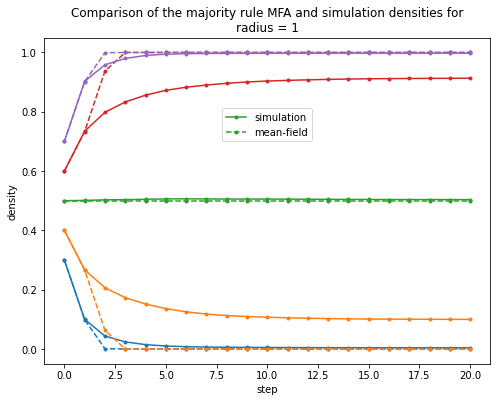

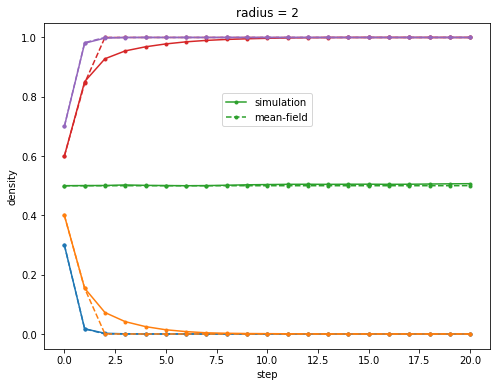

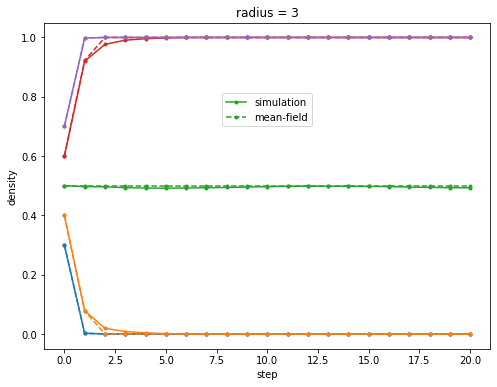

In [ ]:
'''
Compute and plot the evolution of the density of 1s according to the simulation
and the MFA.
'''
for radius in [1, 2, 3]:
    
    plt.figure(figsize=(8, 6))
    if radius == 1:
        plt.title(
            'Comparison of the majority rule MFA and simulation densities for\n'
            'radius = 1')
    else:
        plt.title(f'radius = {radius}')
    plt.xlabel("step")
    plt.ylabel("density")

    for initial_density in np.linspace(0.3, 0.7, 5):
        sim = MajoritySimulator(
            initial_density=initial_density, size=200, radius=radius)

        sim_densities = [np.mean(sim.state)]
        mfa_densities = [sim_densities[0]]
        for step in range(20):
            sim.update()
            sim_densities.append(np.mean(sim.state))
            mfa_densities.append(majority_mfa(mfa_densities[-1], radius))

        line1 = plt.plot(sim_densities, marker='.', linestyle='-')
        color = line1[0].get_color()
        line2 = plt.plot(mfa_densities, color=color, marker='.', linestyle="--")    
        if abs(initial_density-0.5) < 1e-3:
            line1[0].set_label('simulation')
            line2[0].set_label('mean-field')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.667))

plt.show()

The MFA seems to be working better for larger radius. This makes sense as the local variations will diminish with a larger radius. Among the same radius, an initial density closer to the convergence value yielded better accuracy. The inital densities that have to undergo a bigger change to convergence necessarily will have more room to make errors of that change.

The MFA works worse after second step because the output approximations are being calculated using what is already an approximation.

## Traffic Simulator

In [ ]:
class TrafficSimulation:

    def __init__(self, road_length=100, car_density=0.2, prob_slow=0.5,
                 max_speed=5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

    def update(self, optimized=True):
        '''
        Advance one time step in the simulation.
        '''
        if optimized:
            return self.update_optimized()
        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:
                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization
                if (
                    (self.state[i] > 0) and
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = np.full(self.road_length, -1, dtype=int)
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                new_state[(i + cell) % self.road_length] = cell
        self.state = new_state

        # Update average traffic flow history
        self.average_traffic_flow.append(
            sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1

    def update_optimized(self):
        '''
        Advance one time step in the simulation.
        '''
        # Get the location of each car
        car_indexes = np.where(self.state >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # Get the speed of each cars
        car_speeds = self.state[car_indexes]
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + self.road_length])))
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        # Move cars forward using their new speeds
        car_indexes += car_speeds
        car_indexes %= self.road_length
        self.state.fill(-1)
        self.state[car_indexes] = car_speeds

        # Update traffic flow history
        self.average_traffic_flow.append(sum(car_speeds) / self.road_length)
        self.time_step += 1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))

In [ ]:
print('Unoptimized:')
np.random.seed(123)  # Set the seed so we can compare to random simulations
sim = TrafficSimulation(
    road_length=50, car_density=0.3, max_speed=5, prob_slow=0.5)
initial_state = sim.state.copy()
start = time.time()
for i in range(10):
    sim.display()
    sim.update(optimized=False)
end = time.time()
print(f"Time elapsed: {end-start}")

final_state = sim.state.copy()

print()
print('Optimized')
np.random.seed(123)  # Set the seed so we can compare to random simulations
sim = TrafficSimulation(
    road_length=50, car_density=0.3, max_speed=5, prob_slow=0.5)
sim.state = initial_state.copy()
start = time.time()
for i in range(10):
    sim.display()
    sim.update(optimized=True)
end = time.time()
print(f"Time elapsed: {end-start}")


print()
print('Final states match?', np.all(final_state == sim.state))

Unoptimized:
5....1..3.5442....3..2.......54.........43....30..
...3...2.1000...3..1....3....0.....5....0....400..
.....2.0.000.1....2..2......4.1........4.1...00.1.
2....0..1000..1.....2..2.....1..2.......1.1..0.1..
..2..0..000.1..1......2...3...1....3.....1.1.0..1.
2..1..1.00.1.1...2.......3...3.1......3..0.0..1...
.1..1.0.0.1.1..2....3......2.0..1......1..10....2.
...2.10..1.1.1...2......4...1.1..1.......20.1....1
.2..100...1.1..2...2......2.0..1...2.....00..1....
...2000....1..2..2....3....10....2...2...00....2..
Time elapsed: 0.002386331558227539

Optimized
5....1..3.5442....3..2.......54.........43....30..
...3...2.1000...3..1....3....0.....5....0....400..
.....2.0.000.1....2..2......4.1........4.1...00.1.
2....0..1000..1.....2..2.....1..2.......1.1..0.1..
..2..0..000.1..1......2...3...1....3.....1.1.0..1.
2..1..1.00.1.1...2.......3...3.1......3..0.0..1...
.1..1.0.0.1.1..2....3......2.0..1......1..10....2.
...2.10..1.1.1...2......4...1.1..1.......20.1....1
.2..100...1.1..2...2...

In [ ]:
trials = 50 # Number of times to repeat the simulation at each density
densities = np.linspace(0, 1, 101)
average_flows = []  # The results go here

for density in densities:
    flows = []
    for trial in range(trials):
        sim = TrafficSimulation(
            road_length=100,
            car_density=density,
            max_speed=5,
            prob_slow=0.5)
        # Run for 50 steps to reach an equilibrium state
        for step in range(50):
            sim.update()
        # Record the final average traffic flow
        flows.append(sim.average_traffic_flow[-1])
    average_flows.append(flows)
average_flows = np.array(average_flows)

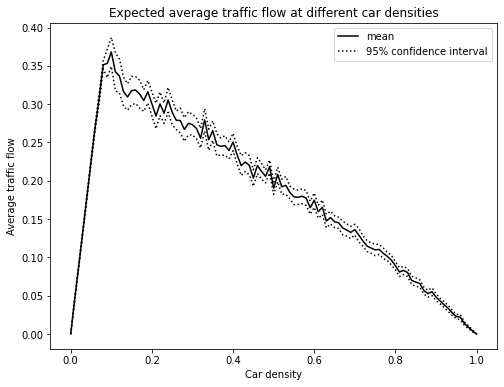

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()

There is an optimal car density where cars flow the best (around $\rho$=0.1), after which the traffic is too congested to flow as efficiently. 

## Traffic MFA

In [ ]:
def traffic_mfa(v, density, p_slow):
    '''
    Calculate the updated distribution over speeds given the current
    distribution by applying the MFA traffic rules.

    Inputs:
    
        v (list of float) The car speed probability vector. v[i] is the
        probability that a car is moving at speed i.

        density (float) The average number of cars per cell on the road.
        
        p_slow (float) The probability of random slow-down.
    
    Returns: A new, updated car speed probability vector.
    '''
    v_max = len(v) - 1
    new_v = [0] * len(v)  # The updated speed probability vector
    for v_from in range(v_max + 1):
        
        # Current speed, will be updated below
        speed = v_from
        
        # Accelerate
        if speed < v_max:
            speed += 1
        
        # Brake when there is a car in front at each distance from 1 to speed
        for distance in range(1, speed + 1):
            # Probability that a car is in front at a particular distance
            car_at_distance = (1-density)**(distance-1) * density
            if distance > 1:
                new_v[distance-1] += v[v_from] * car_at_distance * (1-p_slow)
                new_v[distance-2] += v[v_from] * car_at_distance * p_slow
            else:
                new_v[distance-1] += v[v_from] * car_at_distance
        
        # No cars in front up to distance == speed
        new_v[speed] += v[v_from] * (1-density)**speed * (1-p_slow)
        new_v[speed-1] += v[v_from] * (1-density)**speed * p_slow
        
    return new_v

In [ ]:
def average_speed(v):
    return np.sum(np.array(v) * np.arange(len(v)))

def average_flow(v, density):
    return density * average_speed(v)

max_speed = 5
p_slows = [0, 0.25, 0.5]
car_densities = np.linspace(0, 1, 101)

mfa_flow_results = {}  # map from p_slow to flow results for all densities

for p_slow in p_slows:
    mfa_flow_results[p_slow] = []
    for density in car_densities:
        # Start from a uniform distribution over speeds
        v = [1/(max_speed + 1)] * (max_speed + 1)
        assert abs(sum(v) - 1) < 1e-6  # Sanity check before
        for i in range(100):  # Run until convergence
            v = traffic_mfa(v, density, p_slow)
            assert abs(sum(v) - 1) < 1e-6  # Sanity check after
        mfa_flow_results[p_slow].append(average_flow(v, density))

In [ ]:
trials = 50 # Number of times to repeat the simulation at each density
sim_flow_results = {}  # The results go here

for p_slow in p_slows:
    sim_flow_results[p_slow] = []
    for density in car_densities:
        flows = []
        for trial in range(trials):
            sim = TrafficSimulation(
                road_length=100,
                car_density=density,
                max_speed=max_speed,
                prob_slow=p_slow)
            # Run for 50 steps to reach an equilibrium state
            for step in range(50):
                sim.update()
            # Record the final average traffic flow
            flows.append(sim.average_traffic_flow[-1])
        sim_flow_results[p_slow].append(np.mean(flows))

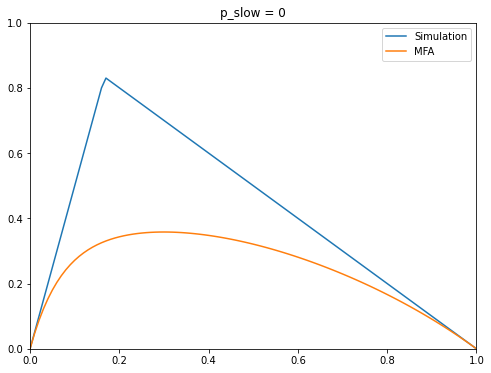

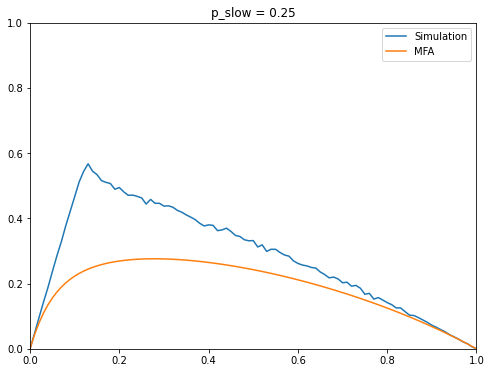

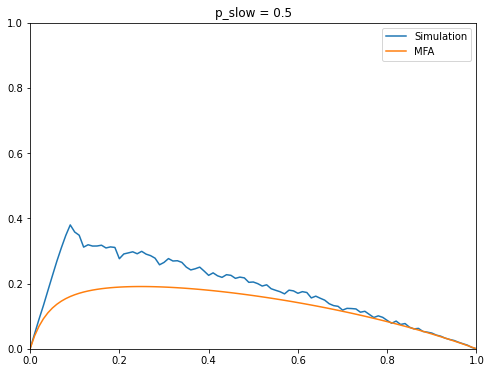

In [ ]:
for p, flow in sim_flow_results.items():
    plt.figure(figsize=(8, 6))
    plt.title(f'p_slow = {p}')
    plt.plot(car_densities, flow, '-', label='Simulation')
    plt.plot(car_densities, mfa_flow_results[p], '-', label='MFA')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()